In [441]:


%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import geopandas as gp
%load_ext autoreload
%autoreload 2
import networkx as nx
from shapely.geometry import Point
from collections import Counter
from networkx import community

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [442]:
dir_path = './datasets'

traffic_df = pd.read_csv("./datasets/Metro_Interstate_Traffic_Volume.csv".format(dir_path))
print('Shape of the dataframe:',traffic_df.shape,'\n')
print('Printing one record:',traffic_df[:1].T)

Shape of the dataframe: (48204, 9) 

Printing one record:                                        0
holiday                              NaN
temp                              288.28
rain_1h                              0.0
snow_1h                              0.0
clouds_all                            40
weather_main                      Clouds
weather_description     scattered clouds
date_time            2012-10-02 09:00:00
traffic_volume                      5545




**Below is the beginning of my work for part 1 of the question. I first seek to describe the numerical features to understand the distributions. Next I use boxplots to visualize distribution over weather and holiday since they are categorical.**



In [443]:
print(f"Temp:\n{traffic_df['temp'].describe()}\n")
print(f"Rain:\n{traffic_df['rain_1h'].describe()}\n")
print(f"Snow:\n{traffic_df['snow_1h'].describe()}\n")
print(f"Clouds:\n{traffic_df['clouds_all'].describe()}\n")

Temp:
count    48204.000000
mean       281.205870
std         13.338232
min          0.000000
25%        272.160000
50%        282.450000
75%        291.806000
max        310.070000
Name: temp, dtype: float64

Rain:
count    48204.000000
mean         0.334264
std         44.789133
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9831.300000
Name: rain_1h, dtype: float64

Snow:
count    48204.000000
mean         0.000222
std          0.008168
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.510000
Name: snow_1h, dtype: float64

Clouds:
count    48204.000000
mean        49.362231
std         39.015750
min          0.000000
25%          1.000000
50%         64.000000
75%         90.000000
max        100.000000
Name: clouds_all, dtype: float64



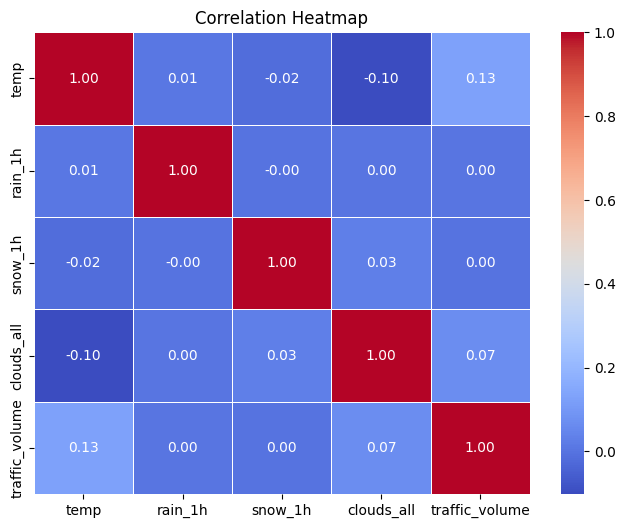

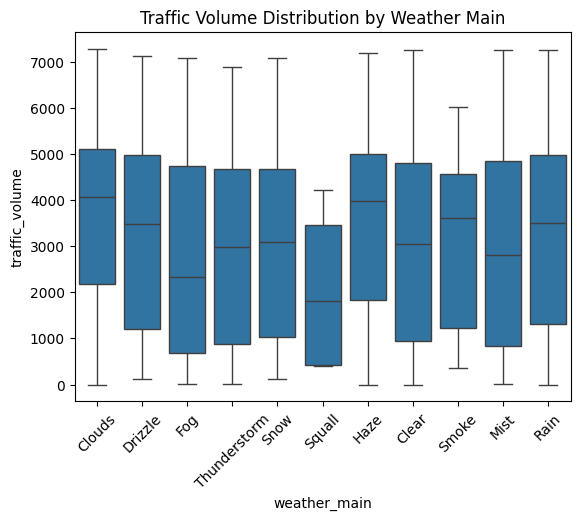

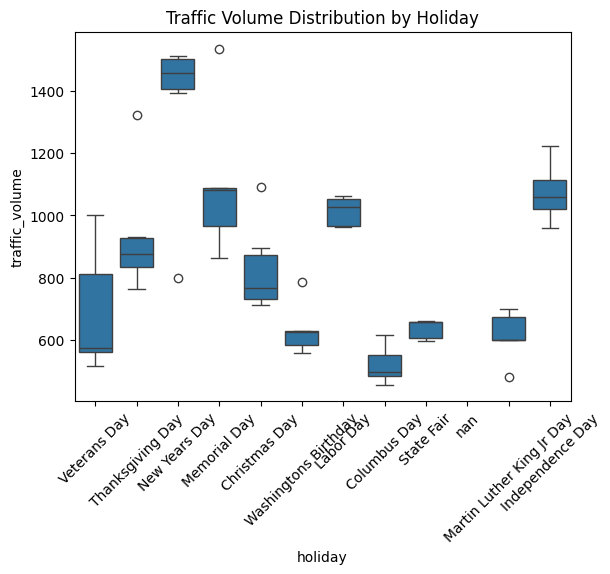

In [444]:
continuous_corr_matrix = traffic_df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(continuous_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.savefig('./figures/raw_data_corr_matrix.png')
plt.show()

sns.boxplot(x='weather_main', y='traffic_volume', data=traffic_df, order=list(set(traffic_df['weather_main'])))
plt.xticks(rotation=45)
plt.title('Traffic Volume Distribution by Weather Main')
plt.savefig('./figures/weather_dist.png')
plt.show()

sns.boxplot(x='holiday', y='traffic_volume', data=traffic_df, order=list(set(traffic_df['holiday'])))
plt.xticks(rotation=45)
plt.title('Traffic Volume Distribution by Holiday')
plt.savefig('./figures/holiday_dist.png')
plt.show()

**----------------------FEATURE ENGINEERING----------------------**

In [445]:
traffic_df['date_time'] = pd.to_datetime(traffic_df['date_time'])
traffic_df['weekend'] = np.where(traffic_df['date_time'].dt.weekday < 4, 0, 1)
traffic_df['holiday'] = np.where(traffic_df['holiday'].isna(), 0, 1)
traffic_df['hour'] = traffic_df['date_time'].dt.hour

traffic_df = traffic_df.drop(['rain_1h', 'snow_1h', 'weather_main', 'weather_description', 'date_time'], axis=1)

In [446]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb

**----------------------REGRESSION MODELS----------------------**

In [ ]:
X = traffic_df.drop('traffic_volume', axis=1)
y = traffic_df['traffic_volume']

LinearReg = LinearRegression()
LinearRegScores = cross_val_score(LinearReg, X, y, cv=3, scoring='r2')

RandForest = RandomForestRegressor()
RandForestScores = cross_val_score(RandForest, X, y, cv=3, scoring='r2')

XGB = xgb.XGBRegressor()
XGBScores = cross_val_score(XGB, X, y, cv=3, scoring='r2')

print(f"-----Regression Models-----")
print(f"Linear Regression Scores: {LinearRegScores.mean():.3f}")
print(f"Random Forest Regression Scores: {RandForestScores.mean():.3f}")
print(f"Extreme Gradient Regression Scores: {XGBScores.mean():.3f}")

-----Regression Models-----
Linear Regression Scores: 0.154
Random Forest Regression Scores: 0.815
Extreme Gradient Regression Scores: 0.848


**----------------------CLASSIFIER MODELS----------------------**

In [448]:
conditions = [traffic_df['traffic_volume'] < 2500, 
                (traffic_df['traffic_volume'] >= 2500) & (traffic_df['traffic_volume'] < 5000),
                (traffic_df['traffic_volume'] >= 5000) & (traffic_df['traffic_volume'] < 7500)]
choices = [0, 1, 2]

traffic_df['volume_bin'] = np.select(conditions, choices, default=3)
traffic_df = traffic_df.drop('traffic_volume', axis=1)

In [ ]:
X = traffic_df.drop('volume_bin', axis=1)
y = traffic_df['volume_bin']

# ChatGPT Portion
LogReg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, solver='lbfgs')
)
LogRegScores = cross_val_score(LogReg, X, y, cv=3, scoring='accuracy')
# End ChatGPT Portion

RandForest = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
RandForestScores = cross_val_score(RandForest, X, y, cv=3, scoring='accuracy')

XGB = xgb.XGBClassifier()
XGBScores = cross_val_score(XGB, X, y, cv=3, scoring='accuracy')

print(f"-----Classifier Models-----")
print(f"Logistic Regression Scores: {LogRegScores.mean():.3f}")
print(f"Random Forest Classifier Scores: {RandForestScores.mean():.3f}")
print(f"Extreme Gradient Classifier Scores: {XGBScores.mean():.3f}")

-----Regression Models-----
Logistic Regression Scores: 0.566
Random Forest Classifier Scores: 0.784
Extreme Gradient Classifier Scores: 0.819
